## Surface and uncertainty maps from final predictions

In [348]:
import os
import functions

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import rasterio

from rasterio.features import shapes
from shapely.geometry import shape, mapping

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

### Parameters

In [349]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [350]:
country = report['Country']
year = report['DHS survey year']
#target_indicator = report['Target Indicator']
target_indicator = report['Target Indicator']

In [351]:
#Load report
with open('temp_files/dfpi.pkl', 'rb') as pickle_file:
    dfpi = pickle.load(pickle_file)

### Load files

In [352]:
# Load the shape file with geographic covariates
shape_path = os.path.join('temp_files/clipped_shape/clipped_shape.shp')
gdf = gpd.read_file(shape_path)

gdf = gdf[['grid_id', 'geometry']]

#Load predictions
with open('temp_files/predictions.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

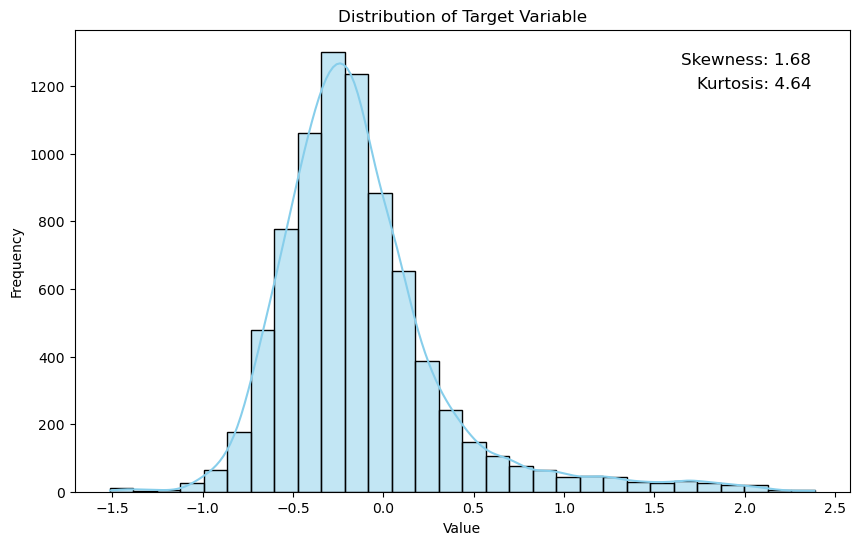

In [353]:
functions.plot_distribution_with_statistics(pd.Series(df[target_indicator]))

### Revert normalization and transform

#Revert standardization
df[target_indicator+'_denormalized'] = functions.revert_standardization(df[target_indicator], 
                                                                        report['Target mean'], 
                                                                        report['Target std'])

In [354]:
# Load the scaler from the pickle file
with open('scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

df[target_indicator+'_untransformed'] = df[target_indicator]

# Use the inverse_transform method to revert to original values
df[target_indicator+'_denormalized'] = scaler_y.inverse_transform(df[target_indicator].values.reshape(-1, 1)).flatten()

#Revert transformation
df[target_indicator] = functions.revert_transformation(df[target_indicator+'_denormalized'], 
                                report['Transformation Applied'],
                                report['Target mean pre transform'], 
                                report['Target std pre transform'], 
                               report['Lambda']).round(4)

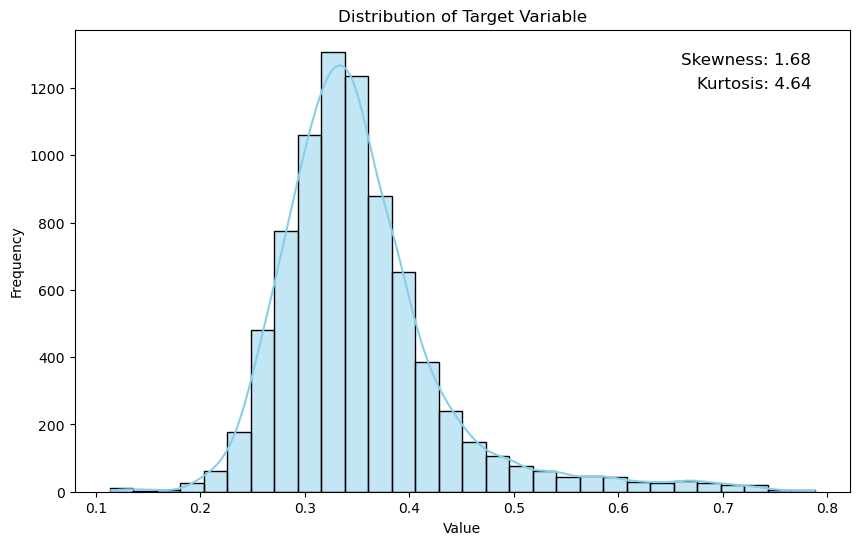

In [355]:
picture_path = os.path.join('temp_files/report', '12. Target Predictions.pdf')
functions.plot_distribution_with_statistics(pd.Series(df[target_indicator]), picture_path)

In [356]:
#Temporarily export results
bayesian_predictions_path = os.path.join('/Users/Daniel/Library/CloudStorage/OneDrive-VestigiumMétodosMixtosAplicadosSAS/proyectos/DISES/SAE/Bayesian-Predictions/bayesian_predictions.xlsx')
df.to_excel(bayesian_predictions_path, index=False)

In [357]:
t1 = df[target_indicator].describe()

In [358]:
t1 = pd.DataFrame(t1).reset_index()

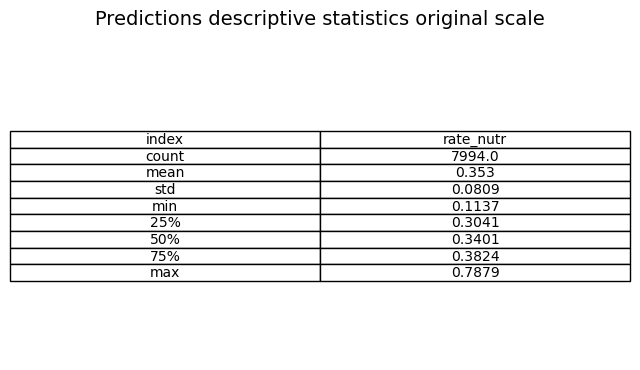

In [359]:
# Plot the DataFrame
table_path = os.path.join('temp_files/report/', '15. Predictions descriptive.pdf')
title = 'Predictions descriptive statistics original scale'
functions.df_to_pdf(t1.round(4), table_path, title=title,  show=True)

In [290]:
#Recalculate ci bounds without the sample size
df['ci_upper'] = df[target_indicator+'_untransformed']+(1.96*df['std'])
df['ci_lower'] = df[target_indicator+'_untransformed']-(1.96*df['std'])

In [291]:
df.columns

Index(['PHUMCODE', 'rate_nutr', 'std', 'max', 'min', 'standard_error',
       'margin_of_error', 'ci_lower', 'ci_upper', 'rate_nutr_untransformed',
       'rate_nutr_denormalized'],
      dtype='object')

In [292]:
#Save original std values
df['std_untransformed'] = df['std']

In [293]:
#Standardize confidence interval bounds
for i in ['ci_upper', 'ci_lower', 'max', 'min', 'std']:
    
    # Use the inverse_transform method to revert to original values
    df[i+'_denormalized'] = scaler_y.inverse_transform(df[i].values.reshape(-1, 1)).flatten()
    
    #Revert transformation
    df[i] = functions.revert_transformation(df[i+'_denormalized'], 
                                    report['Transformation Applied'],
                                    report['Target mean pre transform'], 
                                    report['Target std pre transform'], 
                                    report['Lambda']).round(4)

### Merge with gdf

In [331]:
gdf = gdf.merge(df[['PHUMCODE', target_indicator, 'ci_upper', 'ci_lower', 'std_untransformed', 'std', 'max', 'min', 'standard_error',
       'margin_of_error']], how='left', on='PHUMCODE')

KeyError: "['std_untransformed'] not in index"

### Surface maps

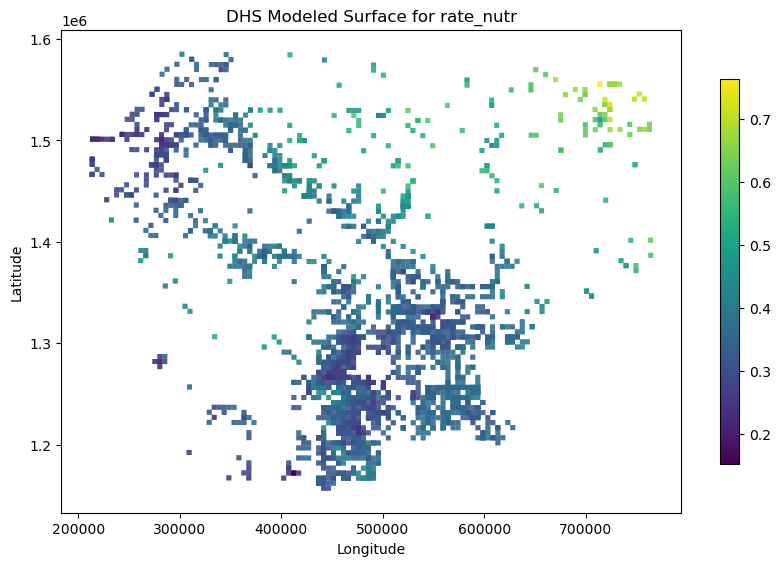

In [277]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a colormap based on the target_indicator
gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.8)

# Customize the plot (optional)
ax.set_title(f'DHS Modeled Surface for {target_indicator}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot again with a legend
gdf_plot = gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.5)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf[target_indicator].min(), vmax=gdf[target_indicator].max()))
sm._A = []  # Create an empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the 'shrink' parameter to reduce color bar size


# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'16. {country} - {year} -  {target_indicator} Predictions.pdf'))

plt.show()

### Uncertainty Quantification

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

Width of the Confidence Interval (ci_width):

    This represents the range between the upper and lower bounds of the confidence interval.

Absolute Confidence Interval (absolute_confidence_interval):

    This is half the width of the confidence interval. It's the margin of error, representing how far the estimate could be from the true population parameter, in absolute terms.

In [258]:
# Adding a column to represent the absolute confidence interval (absolute margin of error)

gdf['ci_width'] = abs(gdf['ci_upper'] - gdf['ci_lower'])
# Adding a column to represent the width of the confidence interval

gdf['absolute_confidence_interval'] = gdf['ci_width'] / 2 #Absolute margin of error

gdf['standardized_uncertainty'] = (gdf['absolute_confidence_interval'] - gdf['absolute_confidence_interval'].mean())  / gdf['absolute_confidence_interval'].std()

### Uncertainty maps

Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

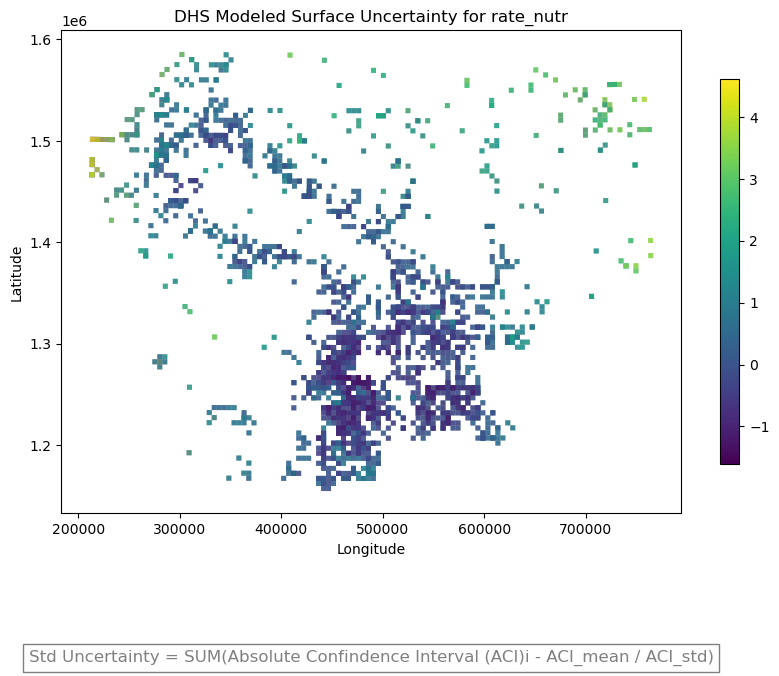

In [259]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a colormap based on the target_indicator
gdf.plot(ax=ax, column=target_indicator, cmap='viridis', alpha=0.8)

# Customize the plot (optional)
ax.set_title(f'DHS Modeled Surface Uncertainty for {target_indicator}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot again with a legend
gdf_plot = gdf.plot(ax=ax, column='standardized_uncertainty', cmap='viridis', alpha=0.5)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf['standardized_uncertainty'].min(), vmax=gdf['standardized_uncertainty'].max()))
sm._A = []  # Create an empty array for the scalar mappable
cbar = fig.colorbar(sm, ax=ax, shrink=0.5)  # Adjust the 'shrink' parameter to reduce color bar size

# Add a note to the plot
note_text = 'Std Uncertainty = SUM(Absolute Confindence Interval (ACI)i - ACI_mean / ACI_std)'

ax.text(0.5, -0.3, note_text, transform=ax.transAxes, fontsize=12, color='gray', 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'17. {country} - {year} -  {target_indicator} Predictions Uncertainty.pdf'))

plt.show()

In [229]:
#Comparte to original distribution
gdf1 = pd.read_pickle('temp_files/selected_features.pkl')

selected_features = gdf1.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

## Precision test (unseen observations)

In [230]:
#Load train subsample used
gdf_sample = pd.read_pickle('temp_files/selected_features_full.pkl')
#Load full dataset
gdf_full = pd.read_pickle('temp_files/selected_features_full.pkl')

In [231]:
#Only observed from train
df1 = gdf_full[~gdf_full[target_indicator].isnull()]
ids_trained_on = df1['grid_id'].to_list()

#Only test 
gdf_test = gdf_full[~gdf_full['grid_id'].isin(gdf_sample['grid_id'].to_list())]

#All rows with observed target
df2 = gdf_full[~gdf_full[target_indicator].isnull()]

#Rows with observed target not trained on (test set)
df_test = df2[~df2['grid_id'].isin(ids_trained_on)]

#### Create a precisión report

In [232]:
precision_report = {}

train_proportion = len(gdf_sample)/len(gdf_full)

test_proportion = len(gdf_test)/len(gdf_full)

precision_report['Train / Test Split'] = f'{round(train_proportion, 4)} / {round(test_proportion, 4)}' 

precision_report['Observations Trained On'] = len(df1)

precision_report['Observations Tested On'] = len(df_test)

#### Compare values to predictions

In [233]:
#Predictions for test
gdf_pred = gdf[gdf['grid_id'].isin(df_test['grid_id'].to_list())]

In [234]:
# Merge the two dataframes on 'grid_id'
df_merged = pd.merge(gdf_pred, df_test, on='grid_id', suffixes=('_pred', '_actual'))

# Extract necessary columns
y_sim = df_merged[f'{target_indicator}_pred']  # Predictions (from your prediction dataframe)
y_obs = df_merged[f'{target_indicator}_actual']  # Observed values (from your actual dataframe)

In [235]:
# Calculate the absolute errors
absolute_errors = np.abs(y_obs - y_sim)

# Calculate the Mean Absolute Error
mae = np.mean(absolute_errors)

print(f"Mean Absolute Error: {round(mae,4)}")

Mean Absolute Error: nan


In [236]:
precision_report["Predictions Mean Absolute Error"] = round(mae, 4)

In [237]:
# Calculate the squared errors
squared_errors = np.square(y_obs - y_sim)

# Calculate the Mean Squared Error (MSE)
mse = np.mean(squared_errors)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {round(rmse,4)}")

Root Mean Squared Error: nan


In [238]:
precision_report["Predictions Root Mean Squared Error"] = round(rmse,4)

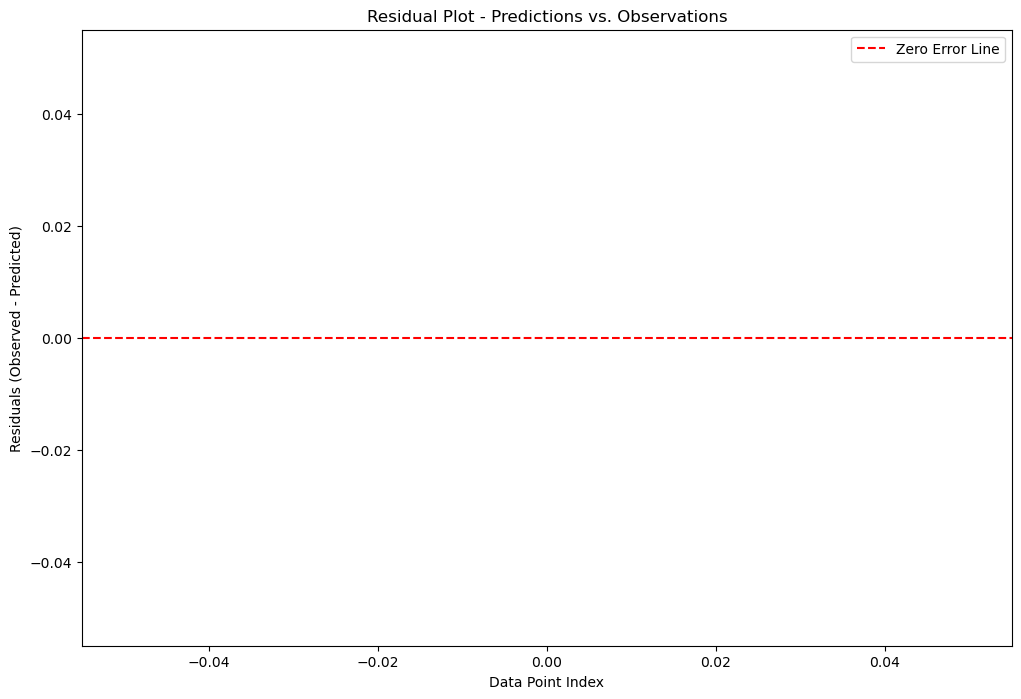

In [239]:
# Calculate residuals
residuals = y_obs - y_sim

# Create residual plot
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(len(y_obs)), residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel('Data Point Index')
plt.ylabel('Residuals (Observed - Predicted)')
title = 'Residual Plot - Predictions vs. Observations'
plt.title(title)
plt.legend()

# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'18. {country} - {year} -  {target_indicator} {title}.pdf'))

plt.show()

ValueError: min() iterable argument is empty

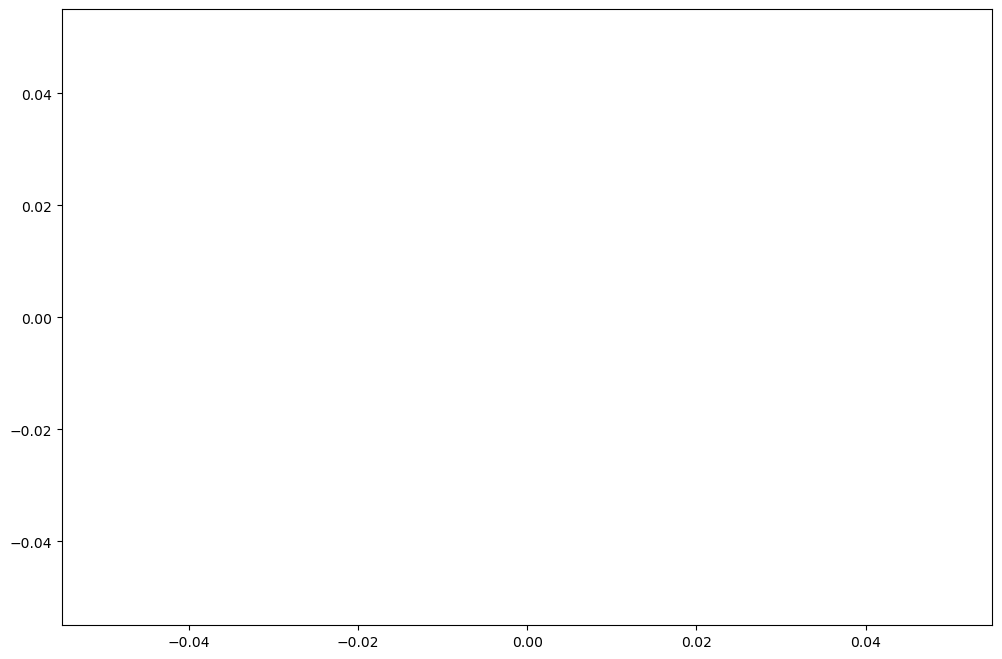

In [149]:
plt.figure(figsize=(12, 8))
plt.scatter(y_obs, y_sim, alpha=0.7, label='Predictions')
plt.plot([min(y_obs), max(y_obs)], [min(y_obs), max(y_obs)], 'r--', label='Perfect Prediction Line')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = 'Scatter Plot - Predictions vs. Observations'
plt.title(title)
plt.legend()

# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'19. {country} - {year} -  {target_indicator} {title}.pdf'))
plt.show()

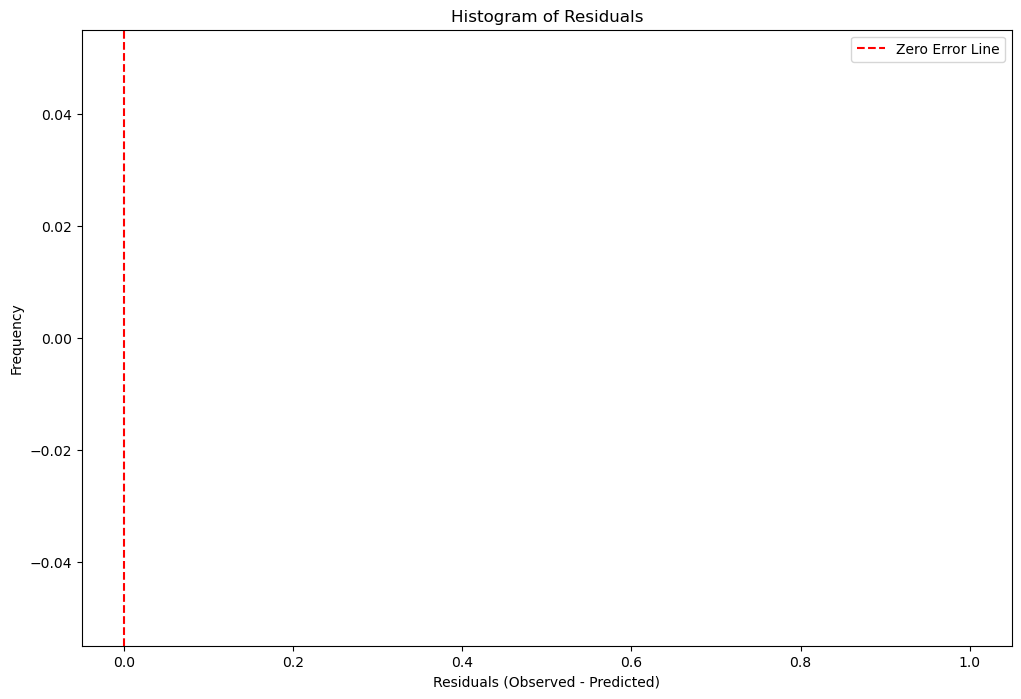

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=20, alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Zero Error Line')
plt.xlabel('Residuals (Observed - Predicted)')
plt.ylabel('Frequency')
title = 'Histogram of Residuals'
plt.title(title)
plt.legend()

# Save the plot as a PDF
plt.savefig(os.path.join('temp_files/report', 
                         f'20. {country} - {year} -  {target_indicator} {title}.pdf'))
plt.show()

### Precision Report

In [ ]:
precision_report['Target mean pre transform'] = report['Target mean pre transform'] 
precision_report['Target std pre transform'] = report['Target std pre transform']

In [ ]:
tpr = pd.DataFrame.from_dict(data=precision_report, columns = ['Value'], orient='index').reset_index()

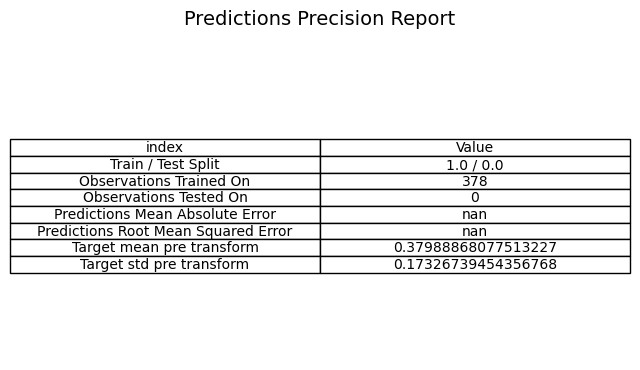

In [ ]:
# Plot the precison repot
table_path = os.path.join('temp_files/report/', '20. Predictions precision report.pdf')
title = 'Predictions Precision Report'
functions.df_to_pdf(tpr.round(4), table_path, title=title,  show=True)

In [ ]:
#Save the report for comparison
destination_path = os.path.join('compared_reports/',f'{country}-{year}-{target_indicator}')
source_path = 'temp_files/report/'
report_name = f'pred-{country}-{year}-{target_indicator}-report.pdf'
functions.create_pdf_report(destination_path, source_path, report_name)

In [ ]:
#Save predictions to share them with the team
predictions_folder_path = os.path.join('predictions/', f'{country}-{year}-{target_indicator}/')
predictions_file_name = f'{country}-{year}-{target_indicator}.shp'
predictions_file_path = os.path.join(predictions_folder_path, predictions_file_name)

In [ ]:
def ensure_folder_exists(file_path):
    # Get the directory from the file path
    folder_path = os.path.dirname(file_path)
    
    # Check if the directory exists
    if not os.path.exists(folder_path):
        # If it doesn't exist, create it
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

In [ ]:
ensure_folder_exists(predictions_folder_path)

Created folder: predictions/KHM-2021-mpi_0


In [ ]:
gdf.to_file(predictions_file_path)

/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_10000/1361974275.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(predictions_file_path)
/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'std_untransformed' to 'std_untran'
  ogr_write(
/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'standard_error' to 'standard_e'
  ogr_write(
/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'margin_of_error' to 'margin_of_'
  ogr_write(
/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'absolute_confidence_interval' to 'absolute_c'
  ogr_write(
/Users/Daniel/miniconda3/envs/p